# Collaborative Filtering with Book Recommendation System
![](https://4.bp.blogspot.com/-jxoN8jvt37w/UPQ8T3XI0aI/AAAAAAAAJXA/v_RQTS3AIkQ/s1600/svdfeature.JPG)
- 協調フィルタリングとアイテムベースレコメンデーションを合わせてレコメンドシステムを構築
- Book-crossing dataset は、2004年にCai-Nicolas Ziegler氏が４週間にもわたるクローリングの末に集めたデータ
- 合計約27万冊の本に対して、約28万人による合計約115万個ものレーティングが付いている

## Step 1. Data Preparation 学習用データの概要

In [1]:
#必要なモジュールをインポートする

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_rows', 300000)

In [2]:
#与えられた「本のデータ」、「ユーザーデータ」、「レーティングデータ」のcsvを3つインポートする

books = pd.read_csv("BX-Books.csv", sep=';', error_bad_lines=False, encoding="latin-1")
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/Users/akr712/.pyenv/versions/jupyter3/lib/python3.5/site-packages/IPython

In [3]:
#各データテーブルの概要を確認
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


### 1-1.  Clean Book Data

In [5]:
#本のデータを確認
books.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
ISBN                   271360 non-null object
Book-Title             271360 non-null object
Book-Author            271359 non-null object
Year-Of-Publication    271360 non-null object
Publisher              271358 non-null object
Image-URL-S            271360 non-null object
Image-URL-M            271360 non-null object
Image-URL-L            271357 non-null object
dtypes: object(8)
memory usage: 16.6+ MB
None


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
#必要なさそうな変数を削除する、列名をシンプルにする
books.drop(labels=["Image-URL-S","Image-URL-M", "Image-URL-L"], axis=1, inplace=True)
books.columns = ["ISBN", "Title", "Author", "Year", "Publisher"]
books.head()

In [6]:
#著者数は約10万人のため、1人の著者につき平均３冊ほどの本がデータ上にあることになる
uniques = books["Book-Author"].nunique()
print(uniques)

102023


,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [7]:
#booksデータのクリーニング
#'Year'列に本来ない文字列を確認できる
print(books["Year"].unique())
books[ (books["Year"]=="Gallimard") | (books["Year"]=="DK Publishing Inc") ]

[2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984 0
 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973 1972
 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950 1967
 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947 1945
 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927 1931
 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917 1901
 2010 1908 1906 1935 1806 2021 '2000' '1995' '1999' '2004' '2003' '1990'
 '1994' '1986' '1989' '2002' '1981' '1993' '1983' '1982' '1976' '1991'
 '1977' '1998' '1992' '1996' '0' '1997' '2001' '1974' '1968' '1987' '1984'
 '1988' '1963' '1956' '1970' '1985' '1978' '1973' '1980' '1979' '1975'
 '1969' '1961' '1965' '1939' '1958' '1950' '1953' '1966' '1971' '1959'
 '1972' '1955' '1957' '1945' '1960' '1967' '1932' '1924' '1964' '2012'
 '1911' '1927' '1948' '1962' '2006' '1952' '1940' '1951' '1931' '1954

,ISBN,Title,Author,Year,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [8]:
#'Author'と'Year'が逆転しているデータを修正

books.loc[books.ISBN=="2070426769","Title"] = "Peuple du ciel, suivi de 'Les Bergers'"
books.loc[books.ISBN=="2070426769","Author"] = "Jean-Marie Gustave Le"
books.loc[books.ISBN=="2070426769","Year"] = 2003
books.loc[books.ISBN=="2070426769","Publisher"] = "Gallimard"

books.loc[books["ISBN"]=="078946697X", "Title"] = "Creating the X-Men, How It All Began (Level 4: Proficient Readers)"
books.loc[books["ISBN"]=="078946697X", "Author"] = "Michael Teitelbaum"
books.loc[books["ISBN"]=="078946697X", "Year"] = 2000
books.loc[books["ISBN"]=="078946697X", "Publisher"] = "DK Publishing Inc"

books.loc[books["ISBN"]=="0789466953", "Title"] = "Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"
books.loc[books["ISBN"]=="0789466953", "Author"] = "James Buckley"
books.loc[books["ISBN"]=="0789466953", "Year"] = 2000
books.loc[books["ISBN"]=="0789466953", "Publisher"] = "DK Publishing Inc"

books["Year"].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [9]:
#'Year'列の０と2005年以降の出版は外れ値なので平均で埋めていく

#まずはobject型からint型に変換
books["Year"] = pd.to_numeric(books["Year"], errors="coerce")

#一度null値に変換して、.fillnaメソッドで出版年の平均を代入していく
books.loc[(books["Year"]==0) | (books["Year"]>2004), "Year"] = np.nan
books["Year"].fillna(round(books["Year"].mean()), inplace=True)
books["Year"].isnull().sum()
books["Year"].unique()

array([2002., 2001., 1991., 1999., 2000., 1993., 1996., 1988., 2004.,
       1998., 1994., 2003., 1997., 1983., 1979., 1995., 1982., 1985.,
       1992., 1986., 1978., 1980., 1952., 1987., 1990., 1981., 1989.,
       1984., 1968., 1961., 1958., 1974., 1976., 1971., 1977., 1975.,
       1965., 1941., 1970., 1962., 1973., 1972., 1960., 1966., 1920.,
       1956., 1959., 1953., 1951., 1942., 1963., 1964., 1969., 1954.,
       1950., 1967., 1957., 1940., 1937., 1955., 1946., 1936., 1930.,
       1925., 1948., 1943., 1947., 1945., 1923., 1939., 1926., 1938.,
       1911., 1904., 1949., 1932., 1928., 1929., 1927., 1931., 1914.,
       1934., 1910., 1933., 1902., 1924., 1921., 1900., 1944., 1917.,
       1901., 1908., 1906., 1935., 1806., 1909., 1378., 1919., 1922.,
       1897., 1376.])

In [10]:
#他のnull値がある列を確認し、修正する

print(books.info())
books.loc[(books["Publisher"].isnull()) | (books["Author"].isnull()), :]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
ISBN         271360 non-null object
Title        271360 non-null object
Author       271359 non-null object
Year         271360 non-null float64
Publisher    271358 non-null object
dtypes: float64(1), object(4)
memory usage: 10.4+ MB
None


,ISBN,Title,Author,Year,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995.0,Edinburgh Financial Publishing


In [11]:
#'Author'と'Publisher'のnull値には、"noname"を代入する
#これでbooksデータはnull値がない綺麗なデータに！

books.loc[books["Publisher"].isnull(), "Publisher"] = np.nan
books["Publisher"].fillna("others", inplace=True)

books.loc[books["Author"].isnull(), "Author"] = np.nan
books["Author"].fillna("noname", inplace=True)

books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
ISBN         271360 non-null object
Title        271360 non-null object
Author       271360 non-null object
Year         271360 non-null float64
Publisher    271360 non-null object
dtypes: float64(1), object(4)
memory usage: 10.4+ MB


### 1-2. Clean User Data

In [12]:
#ユーザーデータを確認
#Ageのnull値（正確には非数値）が多いことがわかる

print(users.info())
print("\n-----行数の確認-----")
print(users.shape)
users.columns = ["UserID", "Location", "Age"]
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
User-ID     278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None

-----行数の確認-----
(278858, 3)


,UserID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64


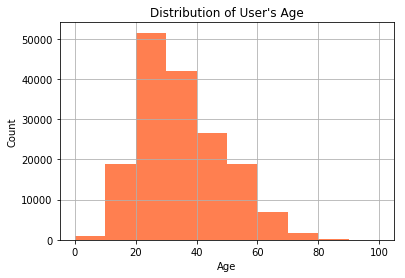

In [13]:
#ユーザー間の本の好みに対して、相関係数がより強そうな変数である年齢の分布をとりあえず調べる
#ユーザーの最大年齢が244歳となっており、外れ値を含んでいることがわかる

print(users["Age"].describe())
plt.hist(users["Age"], bins=[0,10,20,30,40,50,60,70,80,90,100], color="coral")
plt.title("Distribution of User's Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [14]:
#ユーザーデータの年齢の、外れ値とnull値の処理をしていく

print("The number of unique age: ", users["Age"].nunique())
print('--------------------')
age = pd.Series(users["Age"].unique()).sort_values()
print("The head of soted value in 'Age'", "\n", age.head(7))
print('--------------------')
print("The backhead of soted value in 'Age'", "\n", age.tail(7))
print('--------------------')
print("The number of data which has over 100 y.o. in 'Age': ", len(users[users["Age"]>=100]))

The number of unique age:  165
--------------------
The head of soted value in 'Age' 
 47    0.0
57    1.0
79    2.0
72    3.0
84    4.0
90    5.0
93    6.0
dtype: float64
--------------------
The backhead of soted value in 'Age' 
 145    229.0
87     230.0
71     231.0
118    237.0
88     239.0
101    244.0
0        NaN
dtype: float64
--------------------
The number of data which has over 100 y.o. in 'Age':  373


In [15]:
#今回はレビューを残せる可能性が低いと考えられる5歳以下と90歳以上の年齢の値を平均に差し替える
#またnull値に関しても平均を当てる

users.loc[ (users["Age"]<6) | (users["Age"]>90) , "Age"] = np.nan
users["Age"].fillna(round(users["Age"].mean()), inplace=True)
print(sorted(users["Age"].unique()))

[6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0]


## 1-3. Clean Rating Data

In [17]:
#ユーザーデータの年齢がnull値であるデータ数は、全体の1/3以上なので削除せずに平均を入れる)
pd.set_option('display.max_rows', 60)

In [18]:
#レーティングデータを確認
#レーティングデータには本の情報がない

print(ratings.info())
ratings.columns = ["UserID", "ISBN", "Rating"]
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
User-ID        1149780 non-null int64
ISBN           1149780 non-null object
Book-Rating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None


,UserID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


[ 0  5  3  6  8  7 10  9  4  1  2]


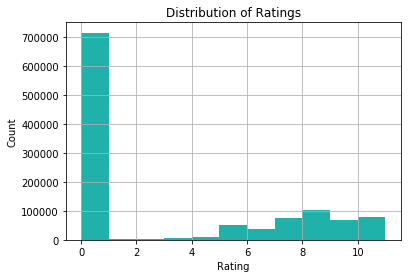

In [19]:
#レーティングの分布を調べる
#レーティングが0のデータが多い

print(ratings["Rating"].unique())
plt.hist(ratings["Rating"],bins=11, range=(0,11), color="lightseagreen")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [20]:
#まずはbooksにデータがない本を削除する
#ほとんどの本がレーティングを持っていることがわかる

ratings_books = ratings[ratings["ISBN"].isin(books["ISBN"])]
print("Original:", len(ratings))
print("Only rating for books in books data:", len(ratings_books))

Original: 1149780
Only rating for books in books data: 1031136


In [21]:
#またデータセットの説明にあるように'Rating'のデータセットのレーティングは、'implicit'と'explicit'な評価がある
#今回、レーティングの値が'0'のデータについては、'implicit'な評価データとして扱う

implicit_ratings = ratings_books[ratings_books["Rating"]==0]
explicit_ratings = ratings_books[ratings_books["Rating"]!=0]

print("The number of implicit ratings data:", len(implicit_ratings))
print("The number of explicit ratings data:", len(explicit_ratings))

explicit_ratings.head()

The number of implicit ratings data: 647294
The number of explicit ratings data: 383842


,UserID,ISBN,Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


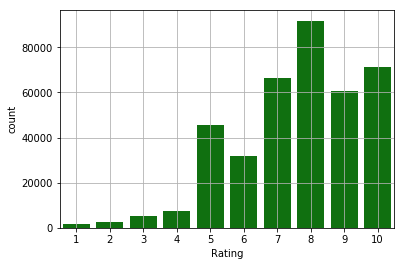

In [22]:
#'explicit'な評価データのみでヒストグラムを再表示

sns.countplot(data=explicit_ratings, x='Rating', color="g")
plt.grid(True)
plt.show()

## Step 2. Build Recommendation System

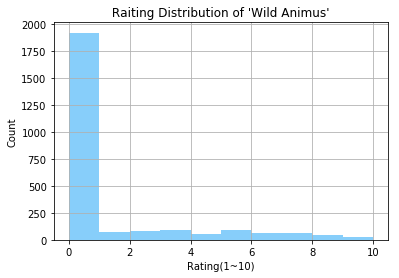

In [23]:
#レーティングがもっとも多い本のレーティングを可視化
#評価0が一番多いという結果に

plt.hist(ratings.loc[ratings["ISBN"]=="0971880107", "Rating"], color="lightskyblue")
plt.title(" Raiting Distribution of 'Wild Animus' ")
plt.xlabel("Rating(1~10)")
plt.ylabel("Count")
plt.grid()
plt.show()

In [24]:
# まずレコメンドの精度を高めるために、与えたレーティング回数が100以上のユーザーと
# 与えられたレーティング個数が100以上ある本のみでモデルを作る
# 与えたレーティング回数が100以上のユーザー数は、449人

users_rating_counts = explicit_ratings["UserID"].value_counts()
over_100 = users_rating_counts.index[users_rating_counts >= 100]
users_100 = explicit_ratings[explicit_ratings["UserID"].isin(over_100)]
print("The number of users with over 100 rating_s:", users_100["UserID"].nunique())
print(users_100["ISBN"].nunique())
users_100.head(10)

The number of users with over 100 rating_s: 449
66574


,UserID,ISBN,Rating
1456,277427,002542730X,10
1458,277427,003008685X,8
1461,277427,0060006641,10
1465,277427,0060542128,7
1474,277427,0061009059,9
1477,277427,0062507109,8
1483,277427,0132220598,8
1488,277427,0140283374,6
1490,277427,014039026X,8
1491,277427,0140390715,7


In [25]:
#与えられたレーティング個数が100以上ある本は、66574冊

books_rating_counts = explicit_ratings["ISBN"].value_counts()
over_100 = books_rating_counts[books_rating_counts.values >= 100]
books_100 = users_100[users_100["ISBN"].isin(over_100.index)]
print("The number of books with over 100 ratings:", books_100["ISBN"].nunique())
books_100.head(10)

The number of books with over 100 ratings: 139


,UserID,ISBN,Rating
1474,277427,0061009059,9
1522,277427,0316776963,8
1581,277427,0385486804,9
1584,277427,0385504209,8
1601,277427,0399501487,9
1647,277427,0440224764,7
6749,278418,0515131229,8
14145,2033,0345337662,5
14155,2033,0439064864,9
14156,2033,0439136350,9


## Key 1：Users（399人）×Books（139冊）の行列を作る
- 十分にレーティングをしているユーザー
- 十分なレーティングがついている本  
上記の2つ条件を満たすマトリクスを作るのが鍵

In [26]:
#上記の条件を満たした、本とユーザーでマトリクスを作ります
matrix = books_100.pivot(index="UserID", columns="ISBN", values="Rating")
print(matrix.shape)
matrix.head(10)

(399, 139)


ISBN,0060392452,0060502258,0060915544,0060928336,0060930535,0060934417,0060938455,0060959037,0060976845,0060987103,...,0786881852,0804106304,0804114986,0805063897,0812550706,0842329129,0971880107,1400034779,1558743669,1573229326
UserID,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6242,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
6251,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Key 2. レーティングの実数値を加える

In [27]:
merge_books = pd.merge(users_100, books, on="ISBN")
print(merge_books.info())
merge_books.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103271 entries, 0 to 103270
Data columns (total 7 columns):
UserID       103271 non-null int64
ISBN         103271 non-null object
Rating       103271 non-null int64
Title        103271 non-null object
Author       103271 non-null object
Year         103271 non-null float64
Publisher    103271 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 6.3+ MB
None


,UserID,ISBN,Rating,Title,Author,Year,Publisher
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc
1,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc
2,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc
3,52584,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc
4,110934,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994.0,John Wiley &amp; Sons Inc


In [28]:
#いらない行を削除する

merge_books.drop(columns = ["Author", "Year", "Publisher"], axis=1, inplace=True)
merge_books.head()

,UserID,ISBN,Rating,Title
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
2,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
3,52584,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,110934,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...


In [30]:
# 各本についているレーティング数を調べる
merge_books.columns = ['UserID', 'ISBN', 'Rating', 'Title']

books_ratings = merge_books.groupby(by=["Title"], as_index=False)["Rating"].count()
books_ratings.columns = ['Title', 'RatingCount']
books_ratings.RatingCount.astype("int")
books_ratings.head()

,Title,RatingCount
0,A Light in the Storm: The Civil War Diary of ...,1
1,Dark Justice,1
2,Earth Prayers From around the World: 365 Pray...,1
3,Final Fantasy Anthology: Official Strategy Gu...,1
4,Good Wives: Image and Reality in the Lives of...,2


In [31]:
merge_books_ratings = merge_books.merge(books_ratings, how="left", left_on="Title", right_on="Title")
merge_books_ratings.head()

,UserID,ISBN,Rating,Title,RatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
1,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,16
2,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
3,52584,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
4,110934,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,16


In [32]:
# 平均1.67このレーティング
books_ratings['RatingCount'].describe()

count    61649.000000
mean         1.675145
std          2.278022
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         72.000000
Name: RatingCount, dtype: float64

In [34]:
# レーティングが15個以上ある本に絞る
popular_books = merge_books_ratings[merge_books_ratings["RatingCount"] >= 15]
popular_books.head()

,UserID,ISBN,Rating,Title,RatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
1,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,16
2,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
3,52584,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
4,110934,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,16


In [55]:
print("レーティングが15個以上ある本の数：",popular_books.Title.nunique())

レーティングが15個以上ある本の数： 359


In [ ]:
# 要素のほとんどが0であるような行列を疎行列と呼ぶ
from scipy.sparse import csr_matrix

popular_books = popular_books.drop_duplicates(['UserID', 'Title'])
popular_books_pivot = popular_books.pivot(index = 'Title', columns = 'UserID', values = 'Rating').fillna(0)

In [57]:
popular_books_pivot

UserID,2033,2110,2276,4017,4385,5582,6242,6251,6543,6575,...,269566,270713,271448,271705,273113,274061,274301,275970,277427,278418
Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
"A Child Called \It\"": One Child's Courage to Survive""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
A Knight in Shining Armor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Map of the World,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
popular_books_matrix = csr_matrix(popular_books_pivot.values)
popular_books_matrix

<359x432 sparse matrix of type '<class 'numpy.float64'>'
	with 7968 stored elements in Compressed Sparse Row format>

In [58]:
popular_books_matrix.shape

(359, 432)

## K-Nearest Neighbors for Books
#### KNNで本の類似度を算出する

In [38]:
# Unsupervised learner for implementing neighbor searches 教師なし
import sklearn
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(popular_books_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [59]:
# ランダムに本を選ぶ
query_index = np.random.choice(popular_books_pivot.shape[0])
query_index

285

In [ ]:
# 類似する本を6つ出力する
distances, indices = model_knn.kneighbors(popular_books_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors=6)

In [61]:
print(distances)
distances.shape

[[0.         0.63806865 0.66218647 0.66257913 0.68960111 0.70243778]]


(1, 6)

In [62]:
indices

array([[285, 159, 299,  12, 254, 217]])

In [39]:
# 類似する本を出力する
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(popular_books_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, popular_books_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The Notebook:

1: Message in a Bottle, with distance of 0.6380686541233241:
2: The Rescue, with distance of 0.6621864728674332:
3: A Walk to Remember, with distance of 0.6625791297393706:
4: The Five People You Meet in Heaven, with distance of 0.6896011097083198:
5: Suzanne's Diary for Nicholas, with distance of 0.7024377802907088:


## Collaborative Filtering Using Matrix Factorization
1. 新しいユーザーAと似たような評価をしている（類似度の高い）ユーザを探す
2. 類似度の高い上位k人の評価を参考に、新しいユーザーAが評価していない作品の評価値を推定する
3. 推定評価値の高い上位10の映画を抽出する

In [41]:
# ユーザー×本の行列、値はレーティング
popular_books_pivot2 = popular_books.pivot(index = 'UserID', columns = 'Title', values = 'Rating').fillna(0)
popular_books_pivot2.head()

Title,1984,1st to Die: A Novel,2nd Chance,84 Charing Cross Road,A Bend in the Road,"A Child Called \It\"": One Child's Courage to Survive""",A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Knight in Shining Armor,A Map of the World,A Painted House,...,White Oleander : A Novel (Oprah's Book Club),Wicked: The Life and Times of the Wicked Witch of the West,Wifey,Wild Animus,Winter Solstice,Wish You Well,"Wizard and Glass (The Dark Tower, Book 4)","Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,"\O\"" Is for Outlaw"""
UserID,,,,,,,,,,,,,,,,,,,,,
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
popular_books_pivot2.shape

(432, 359)

In [43]:
popular_books_pivot2 = popular_books_pivot2.T
popular_books_pivot2.head()

UserID,2033,2110,2276,4017,4385,5582,6242,6251,6543,6575,...,269566,270713,271448,271705,273113,274061,274301,275970,277427,278418
Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [44]:
#ratingデータをISBN(各本ごとの出版ID)ごとでくくる

books_rating = pd.DataFrame(ratings.groupby(by="ISBN")['Rating'].count())
books_rating.sort_values('Rating', ascending=False).head(7)

,Rating
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723
044023722X,647
0679781587,639


In [63]:
popular_books_pivot2.shape

(359, 432)

In [110]:
popular_books_pivot2.to_csv("book_recommendation.csv")

In [45]:
#SVDにより次元を圧縮する
# C=UΣVT
# データ量が減らせることもあって、UΣとVTの2つの行列で持つことが多い
# SVDを使ってレコメンドなど欠測値が多いデータの補完に用いられている

import sklearn
from sklearn.decomposition import TruncatedSVD

# n_componentsは出力の次元 432ユーザーが12次元で表される
SVD = TruncatedSVD(n_components=12, random_state=17)
matrix_factorization = SVD.fit_transform(popular_books_pivot2)
matrix_factorization.shape

(359, 12)

In [69]:
matrix_factorization

array([[ 1.52113600e+01, -1.55109549e+00, -1.43126342e+00, ...,
        -1.58509283e+00, -9.15500408e+00,  2.33155140e+00],
       [ 2.11905316e+01, -5.50346618e+00, -9.59105402e+00, ...,
        -2.22684641e+00, -4.91487891e+00, -9.42981917e-01],
       [ 1.72131123e+01, -2.65812947e+00, -1.03560522e+01, ...,
         8.92537709e+00, -2.34621092e+00, -2.27044896e+00],
       ...,
       [ 1.00407845e+01, -4.77117669e+00,  5.88118887e-01, ...,
        -2.32196999e-01, -4.19846605e+00, -6.51358342e+00],
       [ 8.85947029e+00, -1.33348538e+00,  1.83772760e+00, ...,
         6.72378966e-03,  9.15846681e-01, -2.04128237e+00],
       [ 1.14625668e+01,  3.70470738e-01, -6.87843379e-02, ...,
         2.84755053e+00,  6.75503777e+00, -2.14834501e+00]])

In [46]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
# 相関係数とは、2組のデータの間にどれほどの関係性があるのかを示す1つの指標
corr = np.corrcoef(matrix_factorization)
corr.shape

(359, 359)

In [64]:
# 相関係数
corr

array([[1.        , 0.38388543, 0.2997258 , ..., 0.73514448, 0.7263737 ,
        0.20325453],
       [0.38388543, 1.        , 0.77673848, ..., 0.49927106, 0.12574237,
        0.57351089],
       [0.2997258 , 0.77673848, 1.        , ..., 0.50074437, 0.16613428,
        0.20304302],
       ...,
       [0.73514448, 0.49927106, 0.50074437, ..., 1.        , 0.66586618,
        0.26667364],
       [0.7263737 , 0.12574237, 0.16613428, ..., 0.66586618, 1.        ,
        0.2846214 ],
       [0.20325453, 0.57351089, 0.20304302, ..., 0.26667364, 0.2846214 ,
        1.        ]])

In [47]:
popular_books_title = popular_books_pivot2.index
popular_books_list = list(popular_books_title)
novel = popular_books_list.index('Wish You Well')
print(novel)

354


In [68]:
popular_books_list

['1984',
 '1st to Die: A Novel',
 '2nd Chance',
 '84 Charing Cross Road',
 'A Bend in the Road',
 'A Child Called \\It\\": One Child\'s Courage to Survive"',
 'A Is for Alibi (Kinsey Millhone Mysteries (Paperback))',
 'A Knight in Shining Armor',
 'A Map of the World',
 'A Painted House',
 'A Prayer for Owen Meany',
 'A Time to Kill',
 'A Walk to Remember',
 'A Wrinkle In Time',
 'A Wrinkle in Time',
 "ANGELA'S ASHES",
 'About a Boy',
 'Airframe',
 'All Around the Town',
 'All I Really Need to Know',
 'Along Came a Spider (Alex Cross Novels)',
 'American Gods',
 "Angela's Ashes: A Memoir",
 'Angels &amp; Demons',
 'Animal Farm',
 'Anne Frank: The Diary of a Young Girl',
 'Anne of Avonlea (Anne of Green Gables Novels (Paperback))',
 'Anne of Green Gables (Anne of Green Gables Novels (Paperback))',
 'Artemis Fowl (Artemis Fowl, Book 1)',
 'Ashes to Ashes',
 'At Home in Mitford (The Mitford Years)',
 'Atlas Shrugged',
 'B Is for Burglar (Kinsey Millhone Mysteries (Paperback))',
 'Bag of B

In [70]:
corr_novel = corr[novel]
corr_novel.shape

(359,)

In [89]:
#　類似度の高いTOP10冊のインデックスを取得
novel_top10 = corr_novel.argsort()[-11:-1][::-1]
novel_top10

array([310, 351, 183, 185,  62,  58, 127, 136, 172,  52])

In [90]:
len(popular_books_pivot2)

359

In [91]:
popular_books_pivot2

UserID,2033,2110,2276,4017,4385,5582,6242,6251,6543,6575,...,269566,270713,271448,271705,273113,274061,274301,275970,277427,278418
Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
"A Child Called \It\"": One Child's Courage to Survive""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
A Knight in Shining Armor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Map of the World,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
list(popular_books_pivot2.index)[1]

'1st to Die: A Novel'

In [93]:
top10 = []
for index in novel_top10.tolist():
    book_name = list(popular_books_pivot2.index)[index]
    top10.append(book_name)

In [94]:
top10

['The Switch',
 'Wifey',
 'Open Season',
 'Over the Edge',
 'Confessions of a Shopaholic (Summer Display Opportunity)',
 'Chosen Prey',
 "Hornet's Nest",
 'In Her Shoes : A Novel',
 'Mystic River',
 'Cause of Death']

# Finnaly we built A Book Recommend System!
### You only have to give book name to system
### Then if that book exists in my list, they reply TOP N recommended books

Harry Potterで挑戦！ 残りのTodo. クラスにする

In [97]:
"Harry Potter and the Chamber of Secrets (Book 2)" in popular_books_list

True

In [98]:
name = "Harry Potter and the Chamber of Secrets (Book 2)"
potter = popular_books_list.index(name)
potter

114

In [101]:
corr_potter = corr[potter]
novel_top10 = corr_potter.argsort()[-11:-1][::-1]
top10 = []
for index in novel_top10.tolist():
    book_name = list(popular_books_pivot2.index)[index]
    top10.append(book_name)
top10

['Harry Potter and the Prisoner of Azkaban (Book 3)',
 'Harry Potter and the Goblet of Fire (Book 4)',
 'Harry Potter and the Order of the Phoenix (Book 5)',
 "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
 "Harry Potter and the Sorcerer's Stone (Book 1)",
 'Charlie and the Chocolate Factory',
 'Matilda',
 "Charlotte's Web (Trophy Newbery)",
 'Anne of Avonlea (Anne of Green Gables Novels (Paperback))',
 'The Tao of Pooh']

In [109]:
sorted(corr_potter)[::-1][1:11]

[0.980381907153709,
 0.9469985748784184,
 0.9445808077216458,
 0.9409096663575357,
 0.8694949597442925,
 0.8109917243038648,
 0.7840080652878196,
 0.7443457626718839,
 0.7194709565533179,
 0.6781960514395996]

In [118]:
# ファンクション化！
def reccomend_engine(rating_data, book_name, top_n=10):
    
    SVD = TruncatedSVD(n_components=12, random_state=17)
    matrix_factorization = SVD.fit_transform(rating_data)
    corr = np.corrcoef(matrix_factorization)

    title = popular_books_pivot2.index
    book = list(title).index(book_name)
    book_corr = corr[book]
    top10_index = book_corr.argsort()[-11:-1][::-1]

    top10_book = []
    for index in top10_index.tolist():
        top_book_name = list(popular_books_pivot2.index)[index]
        top10_book.append(top_book_name)

    return top10_book

In [119]:
name1 = "The Little Prince"
mytop10 = reccomend_engine(rating_data=popular_books_pivot2, book_name=name1, top_n=10)
print(mytop10)

["The Sweet Potato Queens' Book of Love", 'A Wrinkle in Time', 'Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players', "The Girls' Guide to Hunting and Fishing", 'The Giver (21st Century Reference)', 'Stupid White Men ...and Other Sorry Excuses for the State of the Nation!', "The Bonesetter's Daughter", 'The Hobbit : The Enchanting Prelude to The Lord of the Rings', 'A Wrinkle In Time', 'The Subtle Knife (His Dark Materials, Book 2)']
